This notebook applies different regression methods to the finalized dataset in search of the best regression model. 

## Data Ingestion and Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_1min = pd.read_csv('dataset-1min.csv')
print(dataset_1min.shape)
dataset_1min.head(3)

(12824, 13)


,datetime,temperature,temperature_f,humidity,co2,light,light_status,noise,bluetooth_devices,image_hist_change,door_status,occupancy_count,occupancy_category
0,2017-03-25 09:05:00,22.6,72.68,36.9,781.0,430.0,light-on,511.0,1.0,15.242697,closed,0.0,very-low
1,2017-03-25 09:05:00,22.6,72.68,36.9,781.0,430.0,light-on,511.0,1.0,15.242697,closed,0.0,very-low
2,2017-03-25 09:06:00,23.8,74.84,38.9,789.0,437.0,light-on,491.0,16.0,15.242697,closed,0.0,very-low


In [3]:
# Delete duplicate rows in the dataset
dataset_1min = dataset_1min.drop_duplicates()
print(dataset_1min.shape)
dataset_1min.head(3)

(8332, 13)


,datetime,temperature,temperature_f,humidity,co2,light,light_status,noise,bluetooth_devices,image_hist_change,door_status,occupancy_count,occupancy_category
0,2017-03-25 09:05:00,22.60,72.68,36.9,781.0,430.000000,light-on,511.000000,1.0,15.242697,closed,0.0,very-low
2,2017-03-25 09:06:00,23.80,74.84,38.9,789.0,437.000000,light-on,491.000000,16.0,15.242697,closed,0.0,very-low
4,2017-03-25 09:07:00,23.85,74.93,38.8,766.0,421.653846,light-on,506.586957,25.0,15.242697,closed,15.0,low


In [4]:
# Subset the features needed 
names = ['temperature', 'humidity', 'co2', 'light', 'noise', 'bluetooth_devices','occupancy_count']
df = dataset_1min[names]
df.head(3)

,temperature,humidity,co2,light,noise,bluetooth_devices,occupancy_count
0,22.60,36.9,781.0,430.000000,511.000000,1.0,0.0
2,23.80,38.9,789.0,437.000000,491.000000,16.0,0.0
4,23.85,38.8,766.0,421.653846,506.586957,25.0,15.0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

In [6]:
# Set occupancy_count as the dependent variable and others as independent variables
data = df.iloc[:,0:-1]
target = df.iloc[:,-1]

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data, target)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6249, 6) (6249,)
(2083, 6) (2083,)


In [7]:
# Standarize data
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

### Lasso Regression
Lasso regression is characterized by the tendancy of the regularization to push the weights of variables to zero. This is useful for our data, because some of our features are highly correlated while others are not useful in predicting occupancy.

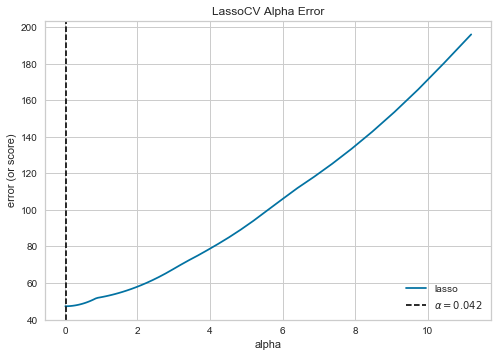

In [8]:
# Select the optimal alpha using Yellowbrick
from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

model = AlphaSelection(LassoCV())
model.fit(X_train, y_train)
model.poof()

In [9]:
lasso = Lasso(alpha = 0.078)
y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
print("Test set R^2: %.4f" 
      % lasso.score(X_test, y_test))
print("Mean squared error: %.4f"
      % np.mean((y_test - y_pred_lasso) ** 2))

Test set R^2: 0.7486
Mean squared error: 49.2921


In [10]:
# Coefficients for each feature
pd.DataFrame(lasso.coef_, names[0:6])

,0
temperature,-1.945128
humidity,-1.263178
co2,10.626593
light,-1.210172
noise,3.511164
bluetooth_devices,-0.000000


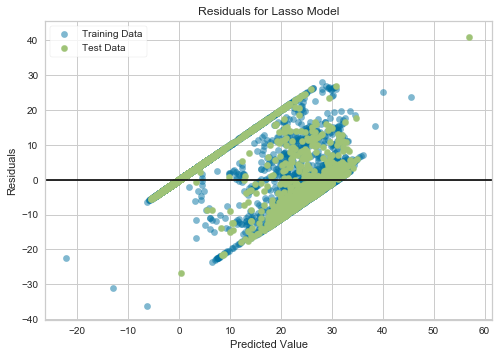

In [11]:
# Plot Regressor evaluation for Lasso 
visualizer_res = ResidualsPlot(lasso)
visualizer_res.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_res.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer_res.poof()

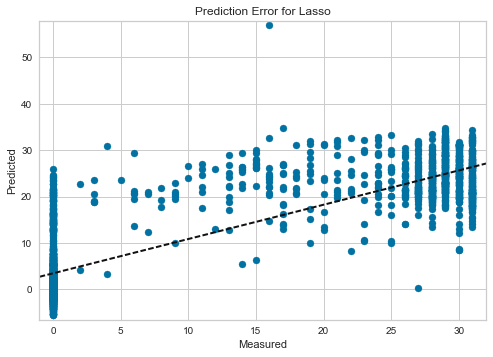

In [12]:
# Plot prediction error plot for Lasso 
visualizer_pre = PredictionError(lasso)
visualizer_pre.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_pre.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer_pre.poof()    

"A residuals plot shows the residuals on the vertical axis and the independent variable on the horizontal axis. If the points are randomly dispersed around the horizontal axis, a linear regression model is appropriate for the data; otherwise, a non-linear model is more appropriate." (http://www.scikit-yb.org/en/latest/examples/methods.html#regressor-evaluation)

Based on the residual plot for Lasso Model, a linear model might not be approporiate for our data. 

### Elastic Net
Elastic net regression is a hybrid approach that blends both penalization of the L2 and L1 norms. Specifically, elastic net regression minimizes the following...

‖y−Xβ‖+λ[(1−α)|β|22+α|β|1]

the α hyper-parameter is between 0 and 1 and controls how much L2 or L1 penalization is used (0 is ridge, 1 is lasso). 
The aggressiveness of the penalty for overfitting is controlled by a parameter λ. The usual approach to optimizing the lambda hyper-parameter is through cross-validation—by minimizing the cross-validated mean squared prediction error—but in elastic net regression, the optimal lambda hyper-parameter also depends upon and is heavily dependent on the alpha hyper-parameter. (http://www.onthelambda.com/2015/08/19/kickin-it-with-elastic-net-regression/)

In [13]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor import PredictionError, ResidualsPlot

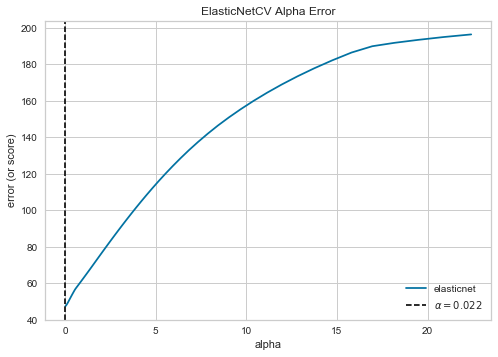

In [14]:
# Hyperparameter tuning with yellowbrick
model = AlphaSelection(ElasticNetCV())
model.fit(X_train, y_train)
model.poof()

In [15]:
# Fit Elastic Net Model using standarized data
elastic = ElasticNet(alpha = 0.022)
y_pred_elastic = elastic.fit(X_train, y_train).predict(X_test)
print("Test set R^2: %.4f" 
      % elastic.score(X_test, y_test))
print("Mean squared error: %.4f"
      % np.mean((y_test - y_pred_elastic) ** 2))

Test set R^2: 0.7487
Mean squared error: 49.2805


In [16]:
# Coefficients for each feature
pd.DataFrame(elastic.coef_, names[0:6])

,0
temperature,-1.953304
humidity,-1.363251
co2,10.482002
light,-1.314821
noise,3.464967
bluetooth_devices,-0.003796


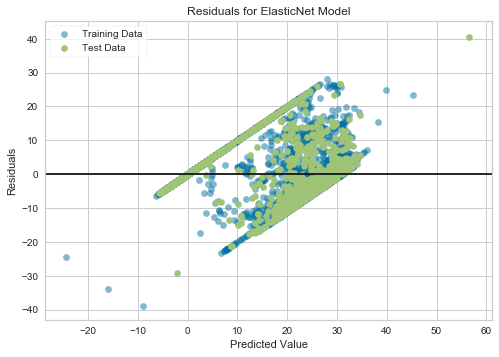

In [17]:
# Regressor evaluation using Yellowbrick
visualizer_res = ResidualsPlot(elastic)
visualizer_res.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_res.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer_res.poof()

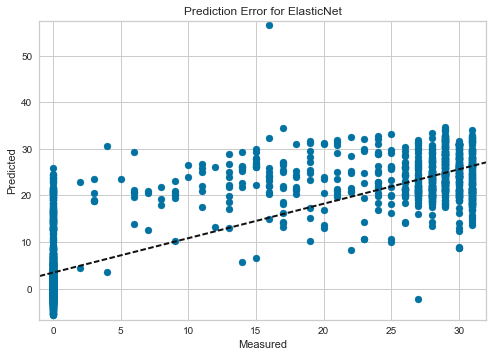

In [18]:
# Instantiate the visualizer and fit
visualizer = PredictionError(elastic)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

### Gradient Boosting Regression

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import grid_search
from yellowbrick.regressor import PredictionError, ResidualsPlot

In [31]:
clf = GradientBoostingRegressor(learning_rate = 0.1, random_state = 0)
parameters = {'max_depth': [7,8,9],'n_estimators':[50,100,150]}
gs = grid_search.GridSearchCV(clf, parameters,cv=5)
gs.fit(X_train,y_train)
gs.grid_scores_

[mean: 0.94939, std: 0.00608, params: {'max_depth': 7, 'n_estimators': 50},
 mean: 0.95477, std: 0.00566, params: {'max_depth': 7, 'n_estimators': 100},
 mean: 0.95651, std: 0.00591, params: {'max_depth': 7, 'n_estimators': 150},
 mean: 0.95214, std: 0.00648, params: {'max_depth': 8, 'n_estimators': 50},
 mean: 0.95651, std: 0.00696, params: {'max_depth': 8, 'n_estimators': 100},
 mean: 0.95731, std: 0.00688, params: {'max_depth': 8, 'n_estimators': 150},
 mean: 0.95504, std: 0.00626, params: {'max_depth': 9, 'n_estimators': 50},
 mean: 0.95791, std: 0.00732, params: {'max_depth': 9, 'n_estimators': 100},
 mean: 0.95837, std: 0.00743, params: {'max_depth': 9, 'n_estimators': 150}]

In [32]:
gs.best_params_

{'max_depth': 9, 'n_estimators': 150}

In [23]:
gbr = GradientBoostingRegressor(max_depth=9, n_estimators=150)
y_pred_gbr = gbr.fit(X_train, y_train).predict(X_test)
print("Test set R^2: %.4f" 
      % gbr.score(X_test, y_test))
print("Mean squared error: %.4f"
      % np.mean((y_test - y_pred_gbr) ** 2))


Test set R^2: 0.9667
Mean squared error: 6.5392


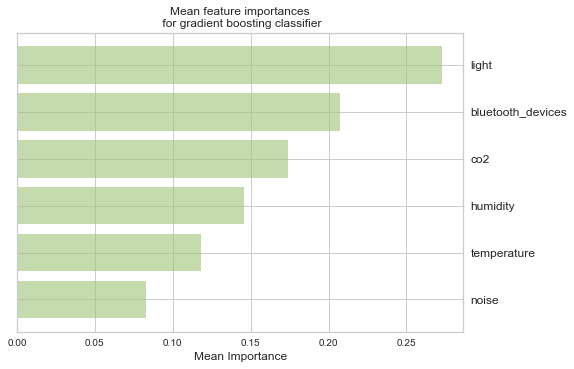

In [35]:
# Plot feature importance
params = names[0:6]
feature_importance = gbr.feature_importances_
sorted_features=sorted(zip(feature_importance,params))
importances,params_sorted=zip(*sorted_features)
#plt.ylim([-1,len()])
plt.barh(range(len(params)),importances,align='center',alpha=0.6,color='g')
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')

plt.yticks(range(len(params)),params_sorted,fontsize=12)
plt.xlabel('Mean Importance',fontsize=12)
plt.title('Mean feature importances\n for gradient boosting classifier')

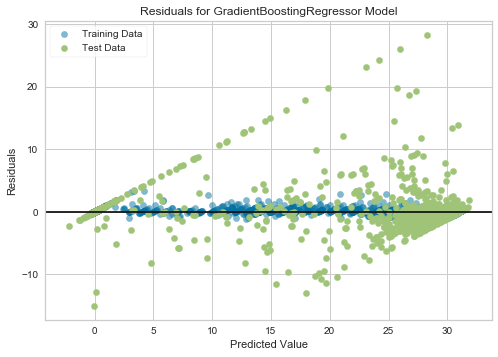

In [25]:
# Plot Regressor evaluation for GradientBoostingRegressor
visualizer_res = ResidualsPlot(gbr)
visualizer_res.fit(X_train, y_train) 
visualizer_res.score(X_test, y_test)  
g = visualizer_res.poof()

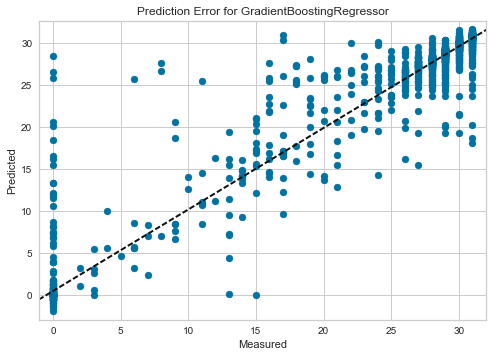

In [26]:
# Plot prediction error plot for GradientBoostingRegressor
visualizer_pre = PredictionError(gbr)
visualizer_pre.fit(X_train, y_train)  
visualizer_pre.score(X_test, y_test)  
g = visualizer_pre.poof() 

### Random Forest Regressor

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import grid_search
from yellowbrick.regressor import PredictionError, ResidualsPlot

In [33]:
rf = RandomForestRegressor(max_features = 'log2')
y_pred_rf = rf.fit(X_train, y_train).predict(X_test)
print("Test set R^2: %.4f" 
      % rf.score(X_test, y_test))
print("Mean squared error: %.4f"
      % np.mean((y_test - y_pred_rf) ** 2))

Test set R^2: 0.9586
Mean squared error: 8.1097


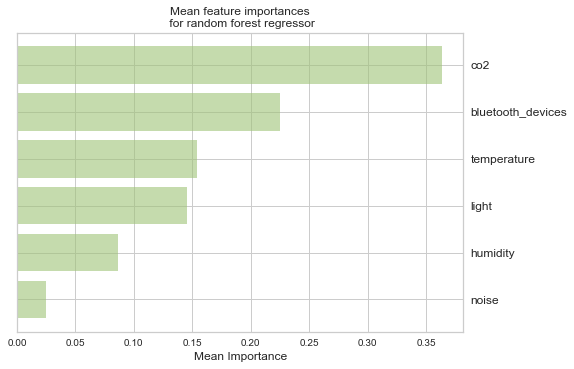

In [37]:
# Plot feature importance
params = names[0:6]
feature_importance = rf.feature_importances_
sorted_features=sorted(zip(feature_importance,params))
importances,params_sorted=zip(*sorted_features)
#plt.ylim([-1,len()])
plt.barh(range(len(params)),importances,align='center',alpha=0.6,color='g')
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')

plt.yticks(range(len(params)),params_sorted,fontsize=12)
plt.xlabel('Mean Importance',fontsize=12)
plt.title('Mean feature importances\n for random forest regressor')

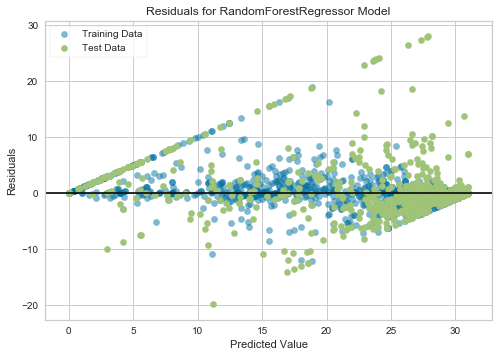

In [30]:
# Plot Regressor evaluation for Lasso using Yellowbrick
visualizer_res = ResidualsPlot(rf)
visualizer_res.fit(X_train, y_train) 
visualizer_res.score(X_test, y_test)  
g = visualizer_res.poof()

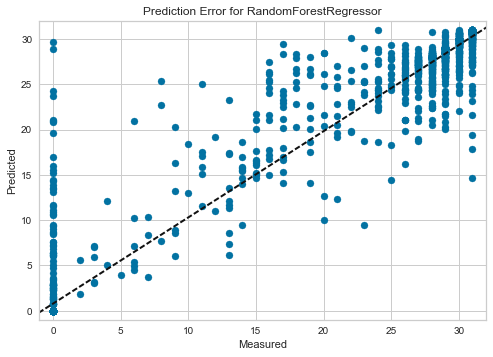

In [36]:
# Plot prediction error plot for RandomForestRegressor
visualizer_pre = PredictionError(rf)
visualizer_pre.fit(X_train, y_train)  
visualizer_pre.score(X_test, y_test)  
g = visualizer_pre.poof() 

### Conclusions
1. Based on the residual plots, linear models such as Lasso and ElasticNet are not the best to describe our data (poor performance for both train data and test data). Non-linear models (RandomForest, Gradient Boosting Regression) perform better (good performance for describing train data at least).

2. Based on r2 score and mean squared error, Gradient Boosting Regression has the best predicting performance among the four models tested. 

3. CO2 demonstrates the highest importance in Lasso, ElasticNet and Random Forest Regressor. For Gradient Boosting Regression, though, light is the most important feature. Noise and temperature has little prediction value in our case, largely due to the restrictions on the data collection process (stable temperature in the classroom, low variability in noises).

4. I'm surprised about how high the prediction scores are for all models tested above (usually above 70% indicates very good model). My guess is certain features (CO2) is highly correlated with occupancy and gives the machine clear "hints" on occupancy. (What do you think?)